In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
import cv2
import multiprocessing
import math
import time
from tqdm import tqdm

# Define Function

In [2]:
def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

In [3]:
class FC():
    """
    Fully connected layer
    """
    def __init__(self, D_in, D_out):
        #print("Build FC")
        self.cache = None
        #self.W = {'val': np.random.randn(D_in, D_out), 'grad': 0}
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        #print("FC: _forward")
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        #print("FC: _backward")
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

In [4]:
class Conv():
    """
    Conv layer
    """
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        #self.W = {'val': np.random.randn(Cout, Cin, F, F), 'grad': 0}
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + self.S
        W_ = W - self.F + self.S
        Y = np.zeros((N, self.Cout, H_, W_))

        for n in range(N):
            for c in range(self.Cout):
                for h in range(H_):
                    for w in range(W_):
                        Y[n, c, h, w] = np.sum(X[n, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :]) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + self.S
        W_ = W - self.F + self.S
        W_rot = np.rot90(np.rot90(self.W['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W['val'].shape)
        db = np.zeros(self.b['val'].shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])

        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        for n in range(N):
            for ci in range(Cin):
                for h in range(H):
                    for w in range(W):
                        #print("self.F.shape: %s", self.F)
                        #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                        dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.F,w:w+self.F])

        return dX

class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        for n in range(N):
            for cin in range(Cin):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
                        M[n,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(Cin):
                #print("(n,c): (%s,%s)" % (n,c))
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M


In [5]:
class Sigmoid():
    """
    Sigmoid activation layer
    """
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        X = np.clip(X, -500, 500)  # 限制X的範圍，避免exp計算時出現溢出
        self.cache = X
        return 1 / (1 + np.exp(-X))

    def _backward(self, dout):
        X = self.cache
        dX = dout*X*(1-X)
        return dX

In [6]:
class Tanh():
    """
    Tanh activation layer
    """
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        self.cache = X
        return np.tanh(X)

    def _backward(self, dout):
        X = self.cache
        dX = dout * (1 - np.tanh(X)**2)
        return dX

In [7]:
class Softmax():
    """
    Softmax activation layer
    """
    def __init__(self):
        #print("Build Softmax")
        self.cache = None

    def _forward(self, X):
        #print("Softmax: _forward")
        maxes = np.amax(X, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(X - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (X, Y, Z)
        return Z # distribution

    def _backward(self, dout):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(dout,dZ)
        dX = np.dot(dX,dY)
        return dX

In [8]:
def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N

class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        # dout = prob.copy()
        # dout[np.arange(N), Y_serial] -= 1
        dout = prob - Y_true
        return loss, dout

In [9]:
class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass

In [10]:
class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])

In [11]:
class Adam():
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, reg=0):
        self.l = len(params)
        self.parameters = params
        self.momentums = []
        self.velocities = []
        for param in self.parameters:
            self.momentums.append(np.zeros(param['val'].shape))
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.reg = reg
        self.t = 0

    def step(self):
        self.t += 1
        for i in range(self.l):
            self.momentums[i] = self.beta1 * self.momentums[i] + (1 - self.beta1) * self.parameters[i]['grad']
            self.velocities[i] = self.beta2 * self.velocities[i] + (1 - self.beta2) * (self.parameters[i]['grad']**2)
            momentums_corrected = self.momentums[i] / (1 - self.beta1**self.t)
            velocities_corrected = self.velocities[i] / (1 - self.beta2**self.t)
            self.parameters[i]['val'] -= (self.lr * momentums_corrected / (np.sqrt(velocities_corrected) + self.epsilon) + self.reg * self.parameters[i]['val'])


In [12]:
def create_mini_batches(image, label, mini_batch_size = 64):
    dataset_size = image.shape[0] # number of training examples
    mini_batches = []
    # partition (image, label). Minus the end case.
    complete_minibatches_number = math.floor(dataset_size / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, complete_minibatches_number):
        mini_batch_image = image[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_label = label[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_image, mini_batch_label)
        mini_batches.append(mini_batch)
    # handle the end case (last mini-batch < mini_batch_size)
    if dataset_size % mini_batch_size != 0:
        mini_batch_image = image[complete_minibatches_number * mini_batch_size: dataset_size, :, :, :]
        mini_batch_label = label[complete_minibatches_number * mini_batch_size: dataset_size]
        mini_batch = (mini_batch_image, mini_batch_label)
        mini_batches.append(mini_batch)
    return mini_batches

In [13]:
def readDataset(image_path):
    num_processes = 16
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_image, image_path)
    return results

def process_image(image_path):
    im = cv2.imread(image_path)
    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(im, (32, 32), interpolation=cv2.INTER_AREA)
    return resized

def load_dataset(train_image, train_label):
    train_image = readDataset(train_image)
    train_image = np.array(train_image)
    train_image = train_image/float(255)
    train_image -= np.mean(train_image)
    train_label = np.array(train_label)
    return (train_image, train_label)


def read_dataset(img_filename):
    filename = []
    label = []
    with open(img_filename, 'r') as f:
        for line in f.readlines():
            s = line.split(' ')
            filename.append(s[0])
            label.append(int(s[1]))
    dataset = []
    for i in range(len(filename)):
        dataset.append((filename[i],label[i]))   
    random.shuffle(dataset)    
    return dataset

# Load Data

In [14]:
dataset_train = read_dataset('train.txt')
dataset_test = read_dataset('test.txt')
dataset_val  = read_dataset('val.txt')

image_paths_train, Y_train = zip(*dataset_train)
image_paths_test, Y_test = zip(*dataset_test)
image_paths_val, Y_val = zip(*dataset_val)

X_train = load_dataset(image_paths_train, Y_train)
X_test  = load_dataset(image_paths_test, Y_test)
X_val   = load_dataset(image_paths_val, Y_val)

# Model Setting

In [15]:
class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(3, 6, 5)
        self.Tanh1 = Tanh()
        self.pool1 = MaxPool(2,2)
        self.Sigmoid1 = Sigmoid()
        self.conv2 = Conv(6, 16, 5)
        self.Tanh2 = Tanh()
        self.pool2 = MaxPool(2,2)
        self.Sigmoid2 = Sigmoid()
        self.FC1 = FC(16*5*5, 120) 
        self.Tanh3 = Tanh()
        self.FC2 = FC(120, 84)
        self.Tanh4 = Tanh()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.Tanh1._forward(h1)
        p1 = self.pool1._forward(a1)
        s1 = self.Sigmoid1._forward(p1)
        h2 = self.conv2._forward(s1)
        a2 = self.Tanh2._forward(h2)
        p2 = self.pool2._forward(a2)
        s2 = self.Sigmoid2._forward(p2)
        self.s2_shape = s2.shape
        fl = s2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.Tanh3._forward(h3)
        h4 = self.FC2._forward(a3)
        a4 = self.Tanh4._forward(h4)
        h5 = self.FC3._forward(a4)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.Tanh4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.Tanh3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.s2_shape) # reshape
        dout = self.Sigmoid2._backward(dout)
        dout = self.pool2._backward(dout)
        dout = self.Tanh2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.Sigmoid1._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.Tanh1._backward(dout)
        dout = self.conv1._backward(dout)
        
    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params
        
    def calculate_flops(self, input_shape):
        # Calculate the number of FLOPs
        input_size = np.prod(input_shape)
        self.num_flops = (input_size * self.conv1.W['val'].size +
                          self.conv1.b['val'].size +
                          self.conv1.W['val'].size * self.conv2.W['val'].size +
                          self.conv2.b['val'].size +
                          self.conv2.W['val'].size * self.FC1.W['val'].size +
                          self.FC1.b['val'].size +
                          self.FC1.W['val'].size * self.FC2.W['val'].size +
                          self.FC2.b['val'].size +
                          self.FC2.W['val'].size * self.FC3.W['val'].size +
                          self.FC3.b['val'].size)
        return(self.num_flops)
    
    def calculate_params(self):
        # Calculate the number of parameters
        self.num_params = sum(param['val'].size for param in self.get_params())
        return(self.num_params)


In [16]:
batch_size = 2048
D_in = X_train[0].shape
D_out = 50
print("batch_size: " + str(batch_size) + ", Input shape: " + str(D_in))
model = LeNet5()
optim = Adam(model.get_params(), lr=0.001)
criterion = CrossEntropyLoss()

batch_size: 2048, Input shape: (63325, 32, 32, 3)


In [17]:
# TRAIN
epoch = 30
start_time = time.time()
error_acc_list = []
for j in range(epoch):    
    start_time_epoch = time.time()
    loss_train = 0
    loss_val   = 0
    train_accuracy = 0
    val_accuracy   = 0
    
    mini_batches_train = create_mini_batches(X_train[0], X_train[1], batch_size)
    mini_batches_val   = create_mini_batches(X_val[0], X_val[1], batch_size)
    print("---------- epoch", j + 1, "begin ----------")
    print("Training:")
    
    for i in tqdm(range(len(mini_batches_train))):
        X_batch, Y_batch = mini_batches_train[i]
        Y_batch = MakeOneHot(Y_batch, D_out)
        X_batch = X_batch.transpose(0, 3, 1, 2)
        Y_pred = model.forward(X_batch)
        loss, dout = criterion.get(Y_pred, Y_batch)
        accuracy = np.sum(np.argmax(Y_pred, axis=1) == np.argmax(Y_batch, axis=1))
        loss_train += loss
        train_accuracy += accuracy  
        model.backward(dout)
        optim.step()
        
    print("Validation:")
    for ii in tqdm(range(len(mini_batches_val))):
        X_batch, Y_batch = mini_batches_val[ii]
        Y_batch = MakeOneHot(Y_batch, D_out)
        X_batch = X_batch.transpose(0, 3, 1, 2)
        Y_pred = model.forward(X_batch)
        loss, dout = criterion.get(Y_pred, Y_batch)
        accuracy = np.sum(np.argmax(Y_pred, axis=1) == np.argmax(Y_batch, axis=1))
        loss_val += loss
        val_accuracy += accuracy  
        
    loss_train = loss_train/i
    loss_val   = loss_val/(ii+1)
    train_accuracy = train_accuracy/len(X_train[1])*100
    val_accuracy   = val_accuracy/len(X_val[1])*100

    print("epoch: %s / %s, Training loss: %.3f, Validation loss: %.3f" % (j+1,epoch, loss_train, loss_val))
    print("Accuracy of Training Data    : %.4f%%" % (train_accuracy))
    print("Accuracy of Validation Data  : %.4f%%" % (val_accuracy))
    print("Time used:", time.time() - start_time_epoch, "sec")
    error_acc_list.append([loss_train, loss_val, train_accuracy, val_accuracy])

# calculate the total training time
total_time =  time.time() - start_time

print("Total time used:", total_time, "sec")


# calculate the average time per epoch
avg_time_per_epoch = total_time / len(error_acc_list[0])

print(f'Total training time: {total_time:.2f} seconds')
print(f'Average time per epoch: {avg_time_per_epoch:.2f} seconds')

error_acc_list = np.array(error_acc_list).T

---------- epoch 1 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:14<00:00, 139.81s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.77s/it]


epoch: 1 / 30, Training loss: 4.043, Validation loss: 3.912
Accuracy of Training Data    : 1.9439%
Accuracy of Validation Data  : 2.0000%
Time used: 4353.986224412918 sec
---------- epoch 2 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:13:01<00:00, 141.35s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.52s/it]


epoch: 2 / 30, Training loss: 4.042, Validation loss: 3.912
Accuracy of Training Data    : 1.9771%
Accuracy of Validation Data  : 2.0000%
Time used: 4401.34635591507 sec
---------- epoch 3 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:43<00:00, 140.77s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.55s/it]


epoch: 3 / 30, Training loss: 4.042, Validation loss: 3.911
Accuracy of Training Data    : 2.2077%
Accuracy of Validation Data  : 1.7778%
Time used: 4383.513080358505 sec
---------- epoch 4 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:34<00:00, 140.48s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.41s/it]


epoch: 4 / 30, Training loss: 4.040, Validation loss: 3.907
Accuracy of Training Data    : 3.2057%
Accuracy of Validation Data  : 4.6667%
Time used: 4374.2162296772 sec
---------- epoch 5 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:17<00:00, 139.93s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.28s/it]


epoch: 5 / 30, Training loss: 4.035, Validation loss: 3.902
Accuracy of Training Data    : 3.5736%
Accuracy of Validation Data  : 4.0000%
Time used: 4356.963879585266 sec
---------- epoch 6 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:50<00:00, 140.99s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.52s/it]


epoch: 6 / 30, Training loss: 4.031, Validation loss: 3.900
Accuracy of Training Data    : 3.6163%
Accuracy of Validation Data  : 4.0000%
Time used: 4390.276053190231 sec
---------- epoch 7 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:42<00:00, 140.72s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.39s/it]


epoch: 7 / 30, Training loss: 4.029, Validation loss: 3.900
Accuracy of Training Data    : 3.9621%
Accuracy of Validation Data  : 3.7778%
Time used: 4381.863862514496 sec
---------- epoch 8 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:25<00:00, 140.17s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.92s/it]


epoch: 8 / 30, Training loss: 4.029, Validation loss: 3.901
Accuracy of Training Data    : 3.8184%
Accuracy of Validation Data  : 2.6667%
Time used: 4365.16571187973 sec
---------- epoch 9 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:13:05<00:00, 141.46s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.77s/it]


epoch: 9 / 30, Training loss: 4.028, Validation loss: 3.898
Accuracy of Training Data    : 3.8737%
Accuracy of Validation Data  : 3.5556%
Time used: 4405.092926740646 sec
---------- epoch 10 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:11:52<00:00, 139.11s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.24s/it]


epoch: 10 / 30, Training loss: 4.028, Validation loss: 3.899
Accuracy of Training Data    : 3.9905%
Accuracy of Validation Data  : 4.2222%
Time used: 4331.71816444397 sec
---------- epoch 11 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:11:47<00:00, 138.96s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.47s/it]


epoch: 11 / 30, Training loss: 4.028, Validation loss: 3.899
Accuracy of Training Data    : 3.9842%
Accuracy of Validation Data  : 4.2222%
Time used: 4327.242390871048 sec
---------- epoch 12 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:04<00:00, 139.50s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.50s/it]


epoch: 12 / 30, Training loss: 4.029, Validation loss: 3.901
Accuracy of Training Data    : 4.0853%
Accuracy of Validation Data  : 3.7778%
Time used: 4344.038365602493 sec
---------- epoch 13 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:11<00:00, 139.71s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.44s/it]


epoch: 13 / 30, Training loss: 4.030, Validation loss: 3.901
Accuracy of Training Data    : 4.0063%
Accuracy of Validation Data  : 3.5556%
Time used: 4350.471807956696 sec
---------- epoch 14 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:13:04<00:00, 141.43s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.29s/it]


epoch: 14 / 30, Training loss: 4.030, Validation loss: 3.902
Accuracy of Training Data    : 4.0584%
Accuracy of Validation Data  : 4.2222%
Time used: 4404.507824420929 sec
---------- epoch 15 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:14<00:00, 139.82s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.56s/it]


epoch: 15 / 30, Training loss: 4.030, Validation loss: 3.901
Accuracy of Training Data    : 4.1042%
Accuracy of Validation Data  : 4.6667%
Time used: 4353.951660871506 sec
---------- epoch 16 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:15<00:00, 139.86s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.32s/it]


epoch: 16 / 30, Training loss: 4.030, Validation loss: 3.901
Accuracy of Training Data    : 4.0916%
Accuracy of Validation Data  : 5.1111%
Time used: 4355.072715997696 sec
---------- epoch 17 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:04<00:00, 139.49s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.36s/it]


epoch: 17 / 30, Training loss: 4.030, Validation loss: 3.900
Accuracy of Training Data    : 4.0884%
Accuracy of Validation Data  : 4.4444%
Time used: 4343.537234783173 sec
---------- epoch 18 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:13<00:00, 139.80s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.93s/it]


epoch: 18 / 30, Training loss: 4.030, Validation loss: 3.900
Accuracy of Training Data    : 4.1026%
Accuracy of Validation Data  : 4.6667%
Time used: 4353.703147649765 sec
---------- epoch 19 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:00<00:00, 139.38s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.84s/it]


epoch: 19 / 30, Training loss: 4.030, Validation loss: 3.901
Accuracy of Training Data    : 4.1500%
Accuracy of Validation Data  : 5.5556%
Time used: 4340.470392465591 sec
---------- epoch 20 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:11:37<00:00, 138.62s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.22s/it]


epoch: 20 / 30, Training loss: 4.029, Validation loss: 3.900
Accuracy of Training Data    : 4.1642%
Accuracy of Validation Data  : 5.5556%
Time used: 4316.47399020195 sec
---------- epoch 21 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:11:26<00:00, 138.26s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.34s/it]


epoch: 21 / 30, Training loss: 4.028, Validation loss: 3.899
Accuracy of Training Data    : 4.1721%
Accuracy of Validation Data  : 5.3333%
Time used: 4305.435661554337 sec
---------- epoch 22 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:07<00:00, 139.60s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.34s/it]


epoch: 22 / 30, Training loss: 4.028, Validation loss: 3.899
Accuracy of Training Data    : 4.2021%
Accuracy of Validation Data  : 5.3333%
Time used: 4347.0691912174225 sec
---------- epoch 23 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:15<00:00, 139.84s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.75s/it]


epoch: 23 / 30, Training loss: 4.027, Validation loss: 3.897
Accuracy of Training Data    : 4.2558%
Accuracy of Validation Data  : 4.6667%
Time used: 4354.799196481705 sec
---------- epoch 24 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:23<00:00, 140.11s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.41s/it]


epoch: 24 / 30, Training loss: 4.027, Validation loss: 3.897
Accuracy of Training Data    : 4.2621%
Accuracy of Validation Data  : 4.8889%
Time used: 4362.92694401741 sec
---------- epoch 25 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:11:38<00:00, 138.66s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.23s/it]


epoch: 25 / 30, Training loss: 4.027, Validation loss: 3.897
Accuracy of Training Data    : 4.2242%
Accuracy of Validation Data  : 4.8889%
Time used: 4317.569237470627 sec
---------- epoch 26 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:10<00:00, 139.69s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.14s/it]


epoch: 26 / 30, Training loss: 4.027, Validation loss: 3.897
Accuracy of Training Data    : 4.1974%
Accuracy of Validation Data  : 5.3333%
Time used: 4349.533795595169 sec
---------- epoch 27 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:08<00:00, 139.62s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.50s/it]


epoch: 27 / 30, Training loss: 4.027, Validation loss: 3.897
Accuracy of Training Data    : 4.2274%
Accuracy of Validation Data  : 4.8889%
Time used: 4347.71923160553 sec
---------- epoch 28 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:55<00:00, 141.16s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.60s/it]


epoch: 28 / 30, Training loss: 4.028, Validation loss: 3.897
Accuracy of Training Data    : 4.2116%
Accuracy of Validation Data  : 4.6667%
Time used: 4395.599858760834 sec
---------- epoch 29 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:57<00:00, 141.20s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.68s/it]


epoch: 29 / 30, Training loss: 4.028, Validation loss: 3.897
Accuracy of Training Data    : 4.2006%
Accuracy of Validation Data  : 5.3333%
Time used: 4396.979953527451 sec
---------- epoch 30 begin ----------
Training:


100%|████████████████████████████████████████| 31/31 [1:12:25<00:00, 140.17s/it]


Validation:


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.88s/it]

epoch: 30 / 30, Training loss: 4.028, Validation loss: 3.898
Accuracy of Training Data    : 4.2479%
Accuracy of Validation Data  : 6.0000%
Time used: 4365.146528244019 sec
Total time used: 130776.39225268364 sec
Total training time: 130776.39 seconds
Average time per epoch: 32694.10 seconds


In [18]:
# Calculate FLOPs for a given input shape
input_shape = (64 ,32, 32, 3)
flops = model.calculate_flops(input_shape)
print("Total FLOPs:", flops)
num_params = model.calculate_params()
print("Number of parameters:", num_params)

Total FLOPs: 730929876
Number of parameters: 65406


In [19]:
# save params
weights = model.get_params()
with open("./params/lenet5_sigmoid_weights.pkl","wb") as f:
	pickle.dump(weights, f)

FileNotFoundError: [Errno 2] No such file or directory: './params/lenet5_sigmoid_weights.pkl'

# Plot Results 

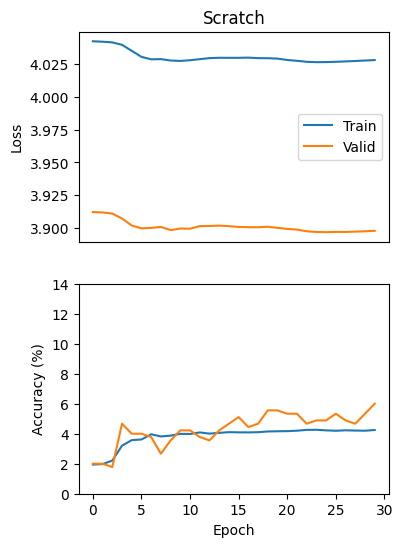

In [20]:
f = plt.figure(figsize=(4,6), dpi=100)
ax = f.add_subplot(211)
plt.title("Scratch")
plt.plot(error_acc_list[0])
plt.plot(error_acc_list[1])
plt.ylabel("Loss")
plt.xticks([])
plt.legend(['Train', 'Valid'])

ax = f.add_subplot(212)
plt.plot(error_acc_list[2])
plt.plot(error_acc_list[3])
# plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim([0, 14])

plt.savefig('./pic/lenet5_scratch.png')

In [23]:
# TEST SET ACC
start_time = time.time()
Y_pred = model.forward(X_test[0].transpose(0, 3, 1, 2))
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)
end_time = time.time()
# calculate the total training time
total_time = end_time - start_time
print("Test --> Correct: " + str(result.count(0)) + " out of " + str(X_test[0].shape[0]) + ", acc=" + str(result.count(0)/X_test[0].shape[0]))
print(total_time)

Test --> Correct: 24 out of 450, acc=0.05333333333333334
19.65289568901062


In [22]:
print("Training Accuracy   = "+ str(error_acc_list[2][-1]) + "%")
print("Validation Accuracy = "+ str(error_acc_list[3][-1]) + "%")

Training Accuracy   = 4.247927358863008%
Validation Accuracy = 6.0%
